# Week 7 Project - Final for PYT305 Intro to Machine Learning with Python
## Austin Maguire

### Dataset Background 
* Dataset: California Fish Market Catch Landings, Long List, 1928-2002, Monthly
* Institution: CA DFG, NOAA ERD
* Dataset ID: erdCAMarCatLM
* Website (data access): https://upwell.pfeg.noaa.gov/erddap/tabledap/erdCAMarCatLM.html
* Website (database information): https://oceanview.pfeg.noaa.gov/las_fish1/doc/names_describe.html

This dataset is made available on the the NOAA (National Oceanic and Atmospheric Administration) ERDDAP data server (Environmental Research Division's Data Access Program). For this analysis I pulled out a subset of the original database focusing just on 'shellfish' - species categorized as crustaceans, echinoderms, and mollusk. I then further defined 'species groups' of common shellfish fishery animals - abalone, clams, crabs, oysters, and shrimp/prawns. 

__The notebooks showing how the original database was accessed are available on the project repository on GitHub.__ 
- **Project Repository**: https://github.com/austinmaguire/ca-historic-shellfish-analysis.git 
- **All Files for PYT305 Final**: https://github.com/austinmaguire/ca-historic-shellfish-analysis/tree/main/PYT305_final_submission


    - *Import from ERDDAP*: notebooks/01_initial_data_import.ipynb
    - *Subset Creation*: notebooks/02_subset_creation.ipynb

## Step 1: Load and Prepare The Data

In [1]:
# Import libraries and modules
import pandas as pd
import numpy as np
from datetime import datetime

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
# Import dataset
shellfish_landings = pd.read_csv('ca_shellfish_landings.csv')

In [3]:
shellfish_landings.head()

,time,year,fish,port,landings
0,1928-01-16T00:00:00Z,1928,"abalone, black",All,0
1,1928-02-16T00:00:00Z,1928,"abalone, black",All,0
2,1928-03-16T00:00:00Z,1928,"abalone, black",All,0
3,1928-04-16T00:00:00Z,1928,"abalone, black",All,0
4,1928-05-16T00:00:00Z,1928,"abalone, black",All,0


In [4]:
# Rename the 'fish' column as 'species'
shellfish_landings = shellfish_landings.rename(columns={'fish':'species'})

In [5]:
shellfish_landings.dtypes

time        object
year         int64
species     object
port        object
landings     int64
dtype: object

In [6]:
# Convert the 'time' column to the pandas datatime format, handle UTC timezone suffix
shellfish_landings['time'] = pd.to_datetime(shellfish_landings['time'], utc=True)

# Create a column for month 
shellfish_landings['month'] = shellfish_landings['time'].dt.month

# Remove rows/observations where there is 0 or no landings recorded
shellfish_landings = shellfish_landings[shellfish_landings['landings'] != 0]

# Remove 'All' port entries to focus on individual ports 
shellfish_landings = shellfish_landings[shellfish_landings['port'] != 'All']

In [7]:
# Specify more common fisheries for investigation - 
abalone = [
    "abalone, black",
    "abalone, flat",
    "abalone, green",
    "abalone, pink",
    "abalone, white",
    "abalone, pinto",
    "abalone, red",
    "abalone, threaded",
    "abalone, unspecified"
]

clams = [
    "clam, gaper",
    "clam, california jackknife",
    "clam, native littleneck",
    "clam, pismo",
    "clam, purple",
    "clam, rosy razor",
    "clam, common washington",
    "clam, unspecified"
]

crabs = [
    "crab, dungeness",
    "crab, rock",
    "crab, brown rock",
    "crab, red rock",
    "crab, yellow rock",
    "crab, king",
    "crab, spider",
    "crab, tanner"
]

oysters = [
    "oyster, california",
    "oyster, eastern",
    "oyster, european flat",
    "oyster, giant pacific",
    "oyster, unspecified"
]

shrimp_prawn = [
    "shrimp, pacific ocean",
    "shrimp, bay",
    "shrimp, red rock",
    "prawn, ridgeback",
    "prawn, spotted",
    "prawn, golden",
    "shrimp, unspecified",
    "prawn, unspecified"
]

In [8]:
# Create a function to categorize species into groups
def get_species_group(species):
   if species in abalone:
       return 'Abalone'
   elif species in clams:
       return 'Clams'
   elif species in crabs:
       return 'Crabs'
   elif species in oysters:
       return 'Oysters'
   elif species in shrimp_prawn:
       return 'Shrimp & Prawns'
   else:
       return 'Other'

In [9]:
# Add species group column
shellfish_landings['species_group'] = shellfish_landings['species'].apply(get_species_group)

In [10]:
# Calculate monthly mean landings by species group
shellfish_landings['monthly_mean_landing'] = shellfish_landings.groupby(
    ['year', 'month', 'species_group', 'port'])['landings'].transform('mean')

In [11]:
def categorize_fishing_success(df):
    def safe_qcut(x):
        try:
            # Try to create quartiles, allowing for duplicate bin edges
            return pd.qcut(x, q=4, labels=['poor', 'fair', 'good', 'excellent'], duplicates='drop')
        except ValueError:
            # If we can't create quartiles (e.g., too few unique values),
            # use the median to create a simple binary classification
            median = x.median()
            return pd.Series(np.where(x > median, 'good', 'poor'), index=x.index)
    
    # Calculate quartiles for each species
    species_quartiles = df.groupby('species')['landings'].transform(safe_qcut)
    
    # Add new column
    df['fishing_success'] = species_quartiles
    
    return df


shellfish_landings = categorize_fishing_success(shellfish_landings)

print(shellfish_landings.groupby(['species', 'fishing_success']).size())

species              fishing_success
abalone, black       excellent          163
                     fair               163
                     good               162
                     poor               163
abalone, flat        good                 4
                                       ... 
shrimp, red rock     poor                35
shrimp, unspecified  excellent          162
                     fair               162
                     good               162
                     poor               162
Length: 143, dtype: int64


## Step 2: Describe The Data
### Dataset Statistics and Metrics: Tables 2(a) - 2(j)
* 2(a) - Summary by Species and Species Group
* 2(b) - Summary by Port
* 2(c) - Top 10 Years by Total Landings
* 2(d) - Basic Statistics for Landings by Species Group
* 2(e) - Percentage of Total Landings by Species Group
* 2(f) - Peak Fishing Month by Species Group
* 2(g) - Average Monthly Landings by Species Group
* 2(h) - Number of Species by Port
* 2(i) - Summary by Species Group and Port
* 2(j) - Summary by Species Group and Year

In [12]:
# Table 2(a): Summary by species and group
# Summary by species
species_summary = shellfish_landings.groupby('species').agg({
    'landings': ['sum', 'mean', 'count']
}).round(2)
species_summary.columns = ['Total_Landings', 'Average_Landings', 'Number_of_Records']
species_summary = species_summary.sort_values('Total_Landings', ascending=False)

# Summary by species group
species_group_summary = shellfish_landings.groupby('species_group').agg({
    'landings': ['sum', 'mean', 'count']
}).round(2)
species_group_summary.columns = ['Total_Landings', 'Average_Landings', 'Number_of_Records']
species_group_summary = species_group_summary.sort_values('Total_Landings', ascending=False)

# Table 2(b): Summary by port
port_summary = shellfish_landings.groupby('port').agg({
    'landings': ['sum', 'mean', 'count']
}).round(2)
port_summary.columns = ['Total_Landings', 'Average_Landings', 'Number_of_Records']
port_summary = port_summary.sort_values('Total_Landings', ascending=False)

# Table 2(c): Summary by year (top 10 by landings)
year_summary = shellfish_landings.groupby('year').agg({
    'landings': ['sum', 'mean', 'count']
}).round(2)
year_summary.columns = ['Total_Landings', 'Average_Landings', 'Number_of_Records']
year_summary = year_summary.sort_values('Total_Landings', ascending=False)

# Print first set of summaries
print("Table 2(a): Summary by Species (Top 10)")
print("=======================================")
print(species_summary.head(10))
print("\nTable 2(b): Summary by Port")
print("===========================")
print(port_summary)
print("\nTable 2(c): Top 10 Years by Total Landings")
print("==========================================")
print(year_summary.head(10))


Table 2(a): Summary by Species (Top 10)
                       Total_Landings  Average_Landings  Number_of_Records
species                                                                   
crab, dungeness             599123273         229022.66               2616
shrimp, pacific ocean       231321107         299638.74                772
abalone, unspecified        147632860          88350.01               1671
oyster, giant pacific       103789289          75264.17               1379
crab, rock                   42907058          15574.25               2755
shrimp, unspecified          35008159          54024.94                648
abalone, red                 11649296          11778.86                989
abalone, black               10446353          16046.63                651
prawn, ridgeback              9818189          17470.09                562
oyster, eastern               8349337          13732.46                608

Table 2(b): Summary by Port
               Total_Landings  

In [13]:
# Calculate basic statistics by species group
species_group_stats = (shellfish_landings.groupby('species_group')['landings']
                      .describe()
                      .round(2))

print("\nTable 2(d): Basic Statistics for Landings by Species Group")
print("======================================================")
print("\nStatistics (in pounds):")
print(species_group_stats)

# Percentage of total landings for each species group
total_landings = shellfish_landings.groupby('species_group')['landings'].sum()
percent_of_total = (total_landings / total_landings.sum() * 100).round(2)

print("\nTable 2(e):Percentage of Total Landings by Species Group:")
print("==========================================")
for group in percent_of_total.index:
    print(f"{group}: {percent_of_total[group]}%")


Table 2(d): Basic Statistics for Landings by Species Group

Statistics (in pounds):
                  count      mean        std  min      25%      50%      75%  \
species_group                                                                  
Abalone          5230.0  33582.46   71789.20  1.0   406.25   3334.0  23712.5   
Clams            2184.0   2277.24    4524.84  1.0   120.00    459.0   2413.5   
Crabs            6549.0  98341.50  481356.13  1.0   673.00   3892.0  24923.0   
Oysters          2299.0  49148.66  160643.19  2.0  2921.50  12213.0  30529.0   
Shrimp & Prawns  3977.0  73246.27  292495.99  1.0   354.00   3515.0  20255.0   

                       max  
species_group               
Abalone           698975.0  
Clams              65000.0  
Crabs            8871792.0  
Oysters          1567818.0  
Shrimp & Prawns  3890438.0  

Table 2(e):Percentage of Total Landings by Species Group:
Abalone: 14.29%
Clams: 0.4%
Crabs: 52.41%
Oysters: 9.19%
Shrimp & Prawns: 23.7%


In [14]:
# Calculate average monthly landings by species group
monthly_patterns = (shellfish_landings.groupby(['month', 'species_group'])['landings']
                   .mean()
                   .round(2)
                   .unstack()
                   .fillna(0))  # Fill NaN with 0 for months with no landings

print("\nTable 2(f): Average Monthly Landings by Species Group")
print("================================================")
print("\nAverage Landings (pounds):")
print(monthly_patterns)

# Calculate and display the peak month for each species group
peak_months = monthly_patterns.idxmax()
print("\nTable 2(g):Peak Fishing Month by Species Group:")
print("======================================")
for species_group in peak_months.index:
    print(f"{species_group}: {peak_months[species_group]}")


Table 2(f): Average Monthly Landings by Species Group

Average Landings (pounds):
species_group   Abalone    Clams      Crabs   Oysters  Shrimp & Prawns
month                                                                 
1              25011.80  1927.83  185820.93  60445.34         11866.12
2                503.90  1999.54  138101.01  55640.10         12099.15
3              22305.55  2044.53  100920.41  59223.68         13364.78
4              39455.31  2221.76   81627.74  47865.54         90735.88
5              40045.39  2676.60   70753.99  46500.06        114649.98
6              35162.01  3382.78   34500.21  24513.05        136384.24
7              39808.77  3313.37   27142.29  19491.31        144196.99
8              56964.93  3349.73   18516.32  20535.30        142011.56
9              35293.78  2113.45   11018.98  39121.08         82970.68
10             30103.40  1993.66    8671.62  64588.34         55881.74
11             29229.85  1760.91   98547.77  74384.97         148

In [15]:
# Print species diversity by port
print("\nTable 2(h): Number of Species by Port")
print("=====================================")
species_diversity = shellfish_landings.groupby('port')['species'].nunique().sort_values(ascending=False)
print(species_diversity)

# Summary by species group and port
group_port_summary = shellfish_landings.pivot_table(
    values='landings',
    index='port',
    columns='species_group',
    aggfunc='sum'
).round(2).fillna(0)
print("\nTable 2(i): Summary by Species Group and Port")
print("=============================================")
print(group_port_summary)

# Summary by species group and year
group_year_summary = shellfish_landings.pivot_table(
    values='landings',
    index='year',
    columns='species_group',
    aggfunc='sum'
).round(2).fillna(0)
print("\nTable 2(j): Summary by Species Group and Year")
print("=============================================")
print(group_year_summary)


Table 2(h): Number of Species by Port
port
San Francisco    32
Santa Barbara    32
Los Angeles      31
San Diego        27
Monterey         25
Eureka           23
Name: species, dtype: int64

Table 2(i): Summary by Species Group and Port
species_group   Abalone    Clams      Crabs   Oysters  Shrimp & Prawns
port                                                                  
Eureka            19474   497360  425472506  72251897        211745877
Los Angeles    42460304   393886   14683758       573          2122818
Monterey       28647841   368279    4083046    318442          1162085
San Diego      11514196   477643    4699507       166           462995
San Francisco   3218487   727840  167719814  25308479         48996435
Santa Barbara  89775960  2508481   27379878  15113219         26810195

Table 2(j): Summary by Species Group and Year
species_group    Abalone     Clams       Crabs    Oysters  Shrimp & Prawns
year                                                                   

## Step 3: Explore The Data
### Visualizing the Dataset: Figures 3(a) - Figure 3(d)
* 3(a) - Monthly Landings by Species Group (with 12-Month Rolling Average)
* 3(b) - Seasonal Patterns by Species Group
* 3(c) - Species Group Composition by Port
* 3(d) - Temporal Success Patterns

In [16]:
# Set style and helper function
sns.set_theme(style="whitegrid")
colors = sns.color_palette("husl", 5)


def format_number(x, pos):
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.1f}K'
    return f'{x:.0f}'

/var/folders/38/c4q60gd93n53zp9cy3yqx8740000gn/T/ipykernel_62202/3451871670.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  [pd.Grouper(freq='M'), 'species_group'])['landings'].sum().reset_index()


<Figure size 1500x800 with 0 Axes>

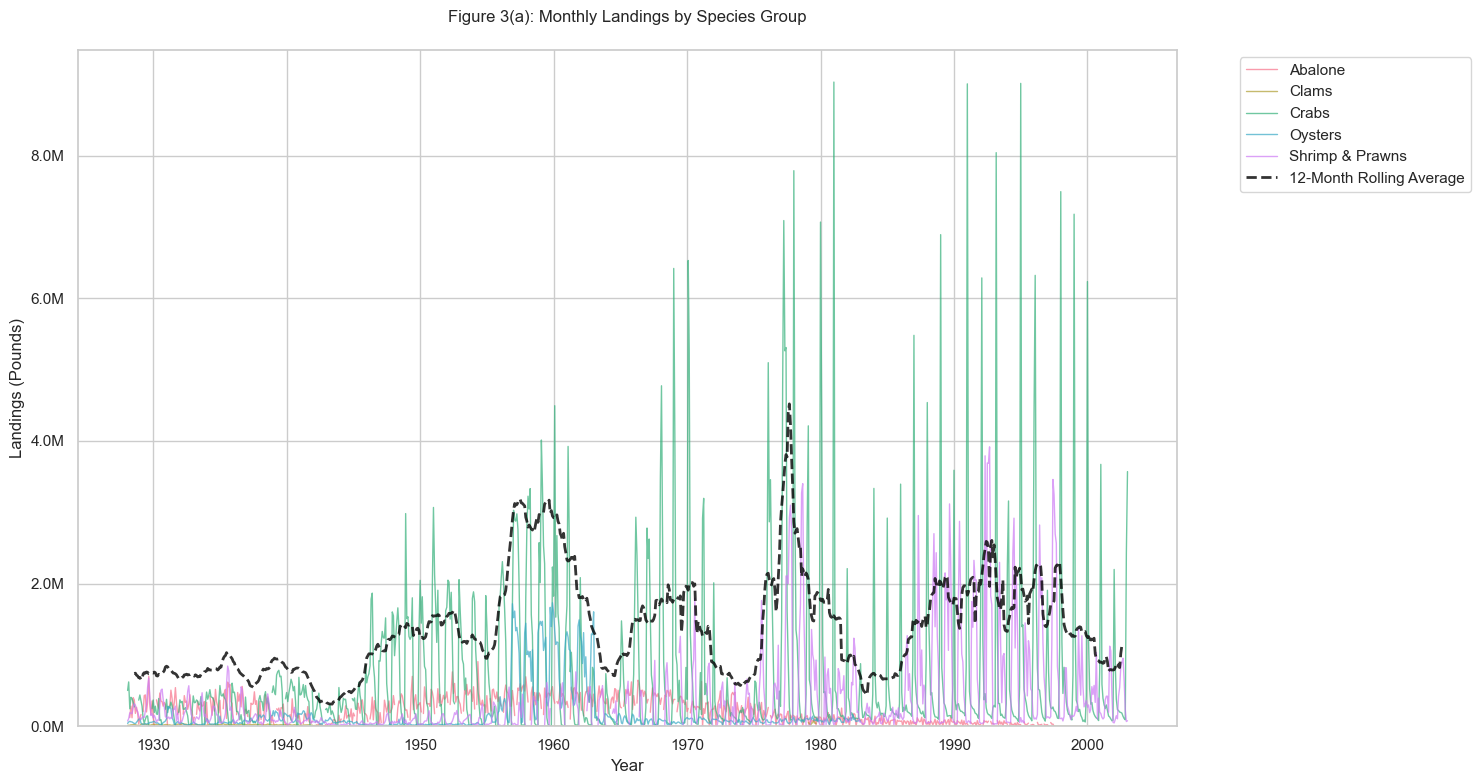

In [17]:
# Figure 3(a): Monthly Total Landings Over Time with Species Groups
plt.figure(figsize=(15, 8))

# Create figure
plt.figure(figsize=(15, 8))

# Create monthly totals by species group with cleaner resampling
monthly_by_group = shellfish_landings.set_index('time').groupby(
    [pd.Grouper(freq='M'), 'species_group'])['landings'].sum().reset_index()
monthly_by_group = monthly_by_group.pivot(index='time', columns='species_group', values='landings')

# Plot each species group with specific colors
for i, species in enumerate(monthly_by_group.columns):
    plt.plot(monthly_by_group.index, monthly_by_group[species], 
             label=species, color=colors[i], alpha=0.7, linewidth=1)

# Calculate and plot 12-month rolling average
total_monthly = monthly_by_group.sum(axis=1)
rolling_avg = total_monthly.rolling(window=12, center=True).mean()
plt.plot(rolling_avg.index, rolling_avg.values,
         color='black', linewidth=2, linestyle='--',
         label='12-Month Rolling Average', alpha=0.8)

# Customize the plot
plt.title('Figure 3(a): Monthly Landings by Species Group', pad=20)
plt.xlabel('Year')
plt.ylabel('Landings (Pounds)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Adjust legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Set y-axis limit to reduce empty space
plt.ylim(bottom=0)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

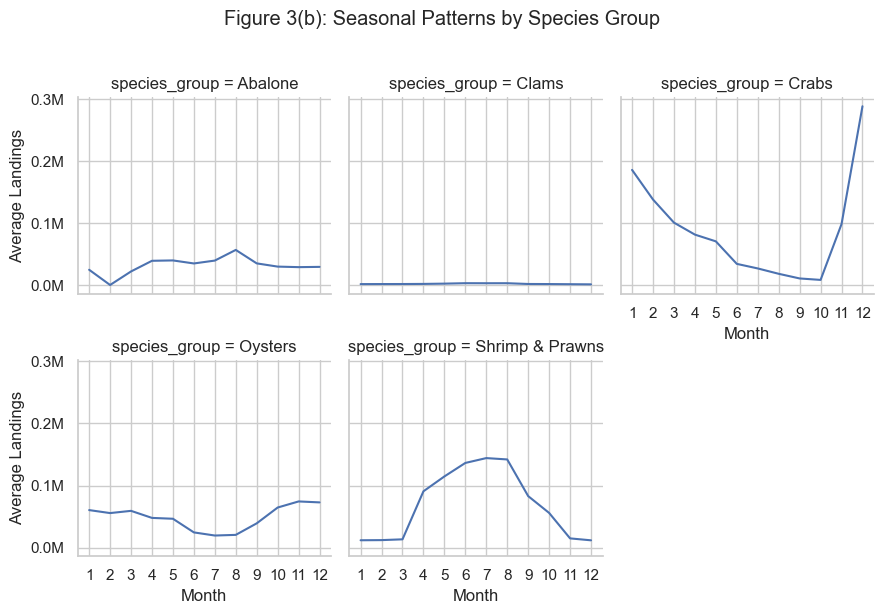

In [18]:
# Figure 3(b): Seasonal Patterns by Species Group
plt.figure(figsize=(12, 8))

# Calculate and plot seasonal patterns
seasonal_data = shellfish_landings.groupby(['month', 'species_group'])['landings'].mean().reset_index()
g = sns.FacetGrid(seasonal_data, col='species_group', col_wrap=3, height=3)
g.map_dataframe(sns.lineplot, x='month', y='landings')

# Customize subplots
for ax in g.axes:
    ax.set_xticks(range(1, 13))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Landings')

plt.suptitle('Figure 3(b): Seasonal Patterns by Species Group', y=1.02)
plt.tight_layout()
plt.show()

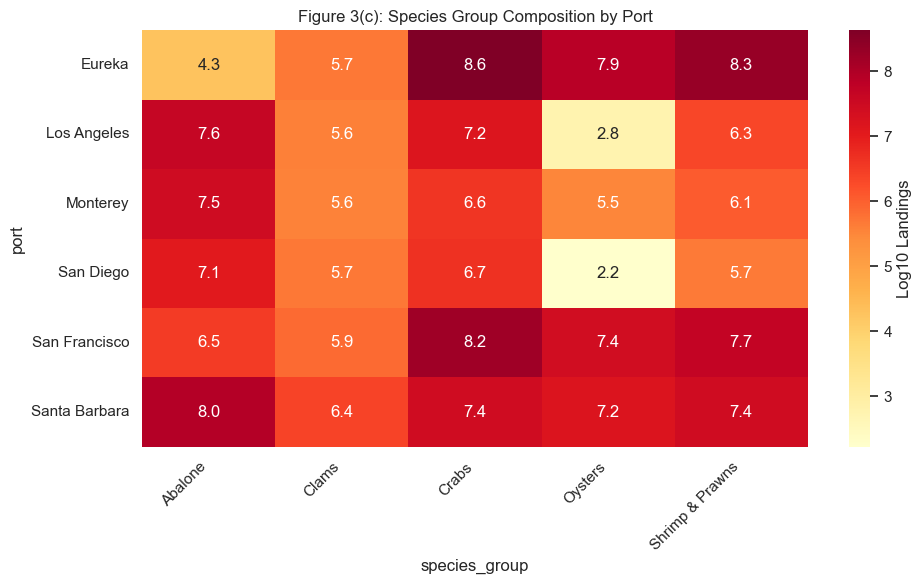

In [19]:
# Figure 3(c): Species Group and Port Heatmap
plt.figure(figsize=(10, 6))

# Create and normalize heatmap data
heatmap_data = pd.pivot_table(shellfish_landings, 
    values='landings', 
    index='port',
    columns='species_group',
    aggfunc='sum'
)
heatmap_normalized = np.log10(heatmap_data + 1)

# Create heatmap
sns.heatmap(heatmap_normalized, cmap='YlOrRd', annot=True, fmt='.1f', 
            cbar_kws={'label': 'Log10 Landings'})

plt.title('Figure 3(c): Species Group Composition by Port')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



### Create a 'Success Score' Calculation and Visualize

The success score for each time period is calculated as:

$$ \text{Success Score} = \frac{\sum_{i=1}^{n} w_i x_i}{n} \times 100 $$

where:
- $w_i$ is the weight for each category: 
  - $w_{excellent} = 1.0$
  - $w_{good} = 0.66$
  - $w_{fair} = 0.33$
  - $w_{poor} = 0$
- $x_i$ is the occurrence of each category
- $n$ is the total number of observations in that period

This creates a normalized score between 0-100%, where:
- 100% would indicate all landings were 'excellent'
- 0% would indicate all landings were 'poor'

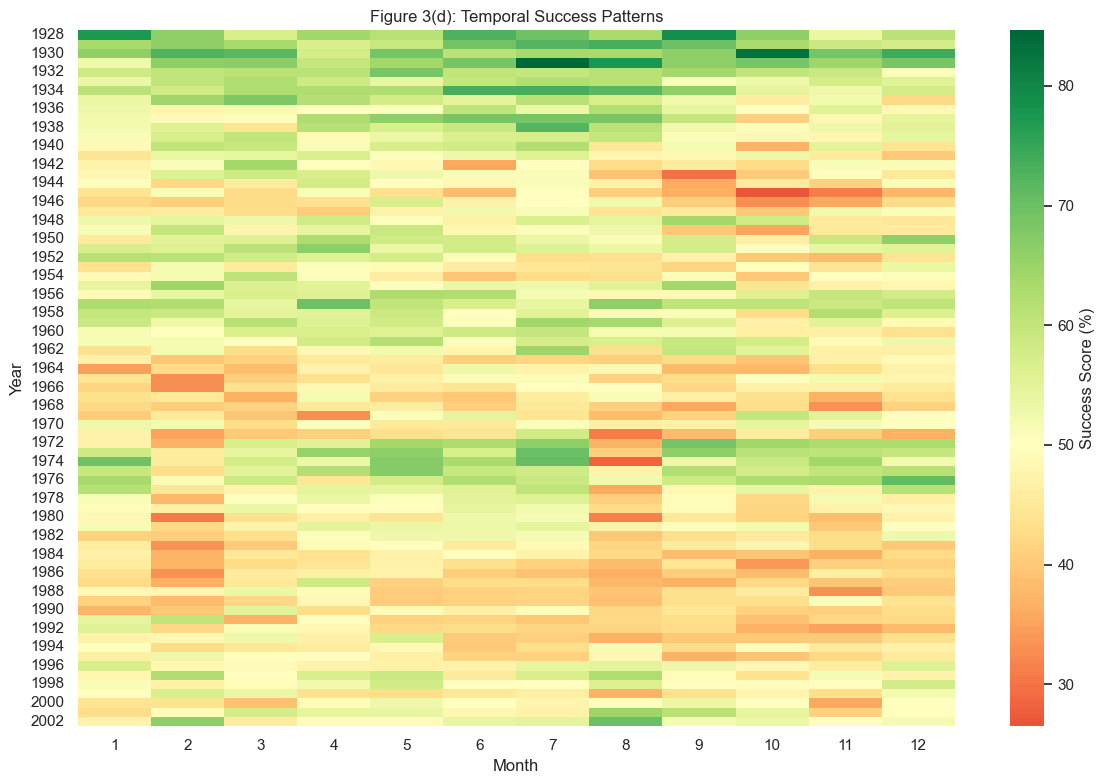

In [20]:
# Figure 3(d): Success Patterns Calendar Heatmap
plt.figure(figsize=(12, 8))

# Calculate success score (weighted average)
def success_score(x):
    weights = {'excellent': 1.0, 'good': 0.66, 'fair': 0.33, 'poor': 0}
    return sum(x.map(weights)) / len(x) * 100

# Calculate and pivot weighted success rate data
success_data = shellfish_landings.groupby(['year', 'month'])['fishing_success'].apply(success_score).reset_index()
success_pivot = pd.pivot_table(success_data, 
                             values='fishing_success',
                             index='year',
                             columns='month')

# Create success rate heatmap
sns.heatmap(success_pivot, cmap='RdYlGn', center=50,
            cbar_kws={'label': 'Success Score (%)'})

plt.title('Figure 3(d): Temporal Success Patterns')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

## Step 4: Building The Models

### Model Notes 
There were a number of different modeling attempts and iterations for this project. Notes on each is in Step 6 below. Turning in one of the iterations that shows the most of code we learned in class.
The modelings attempts were- 
* A linear regression and ARIMA time series approach 
* Standard classification with Random Forest and Naive Bayes
* __Random Forest and Naive Bayes with enhanced features (presented below)__
* A species group specific classification using just the crab group data

In [21]:
# Create label encoders for categorical variables
le_species = LabelEncoder()
le_port = LabelEncoder()
le_season = LabelEncoder()

# Create enhanced feature set
X = shellfish_landings[['species_group', 'port', 'month', 'year']].copy()

# Add seasonal features
X['season'] = np.where(X['month'].isin([12,1,2]), 'Winter',
                np.where(X['month'].isin([3,4,5]), 'Spring',
                np.where(X['month'].isin([6,7,8]), 'Summer', 'Fall')))

# Add cyclical month encoding
X['month_sin'] = np.sin(2 * np.pi * X['month']/12)
X['month_cos'] = np.cos(2 * np.pi * X['month']/12)

# Encode categorical variables
X['species_group'] = le_species.fit_transform(X['species_group'])
X['port'] = le_port.fit_transform(X['port'])
X['season'] = le_season.fit_transform(X['season'])

# Convert target to numeric
le_success = LabelEncoder()
y = le_success.fit_transform(shellfish_landings['fishing_success'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nClass distribution in test set:")
print(pd.Series(y_test).value_counts(normalize=True))

# Train Naive Bayes
print("\nFitting Naive Bayes Model...")
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)

# Train Random Forest
print("\nFitting Random Forest Model...")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

Training set shape: (16191, 7)
Testing set shape: (4048, 7)

Class distribution in training set:
3    0.251312
2    0.251251
0    0.249583
1    0.247854
Name: proportion, dtype: float64

Class distribution in test set:
1    0.257658
0    0.251482
3    0.250494
2    0.240366
Name: proportion, dtype: float64

Fitting Naive Bayes Model...

Fitting Random Forest Model...


## Step 5: Evaluate The Model Performance

In [22]:
# Evaluate Naive Bayes
print("\nNaive Bayes Results:")
print("--------------------")
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, nb_pred) * 100))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, nb_pred))
print("\nClassification Report:")
print(classification_report(y_test, nb_pred,
                          target_names=['poor', 'fair', 'good', 'excellent']))

# Evaluate Random Forest
print("\nRandom Forest Results:")
print("---------------------")
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, rf_pred) * 100))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, rf_pred))
print("\nClassification Report:")
print(classification_report(y_test, rf_pred,
                          target_names=['poor', 'fair', 'good', 'excellent']))

# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance)


Naive Bayes Results:
--------------------
Accuracy: 30.06%

Confusion Matrix:
[[385  87 297 249]
 [248 111 269 415]
 [291  72 281 329]
 [244  86 244 440]]

Classification Report:
              precision    recall  f1-score   support

        poor       0.33      0.38      0.35      1018
        fair       0.31      0.11      0.16      1043
        good       0.26      0.29      0.27       973
   excellent       0.31      0.43      0.36      1014

    accuracy                           0.30      4048
   macro avg       0.30      0.30      0.29      4048
weighted avg       0.30      0.30      0.29      4048


Random Forest Results:
---------------------
Accuracy: 42.02%

Confusion Matrix:
[[531 149 215 123]
 [159 356 242 286]
 [236 215 365 157]
 [161 238 166 449]]

Classification Report:
              precision    recall  f1-score   support

        poor       0.49      0.52      0.50      1018
        fair       0.37      0.34      0.36      1043
        good       0.37      0.38      

Naive Bayes Confusion Matrix:


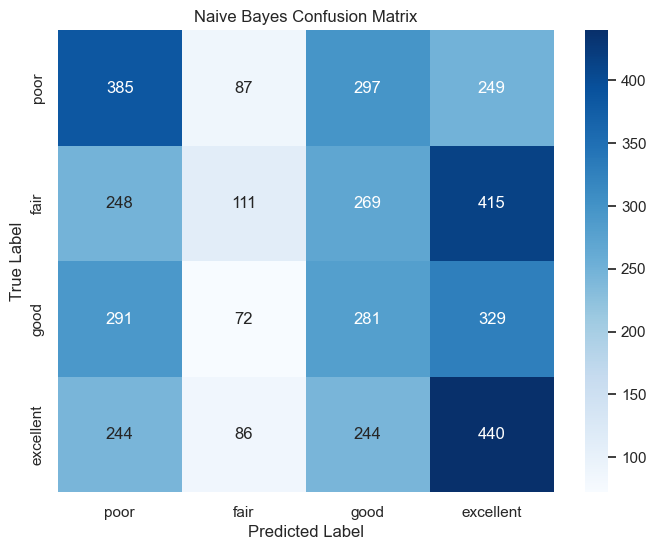


Random Forest Confusion Matrix:


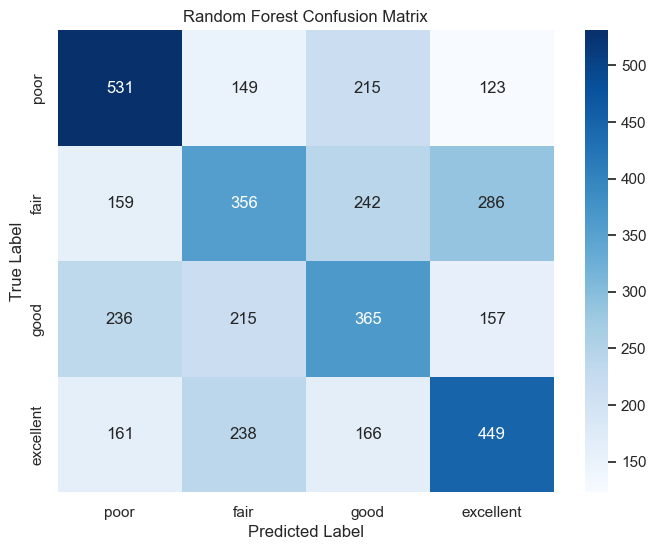

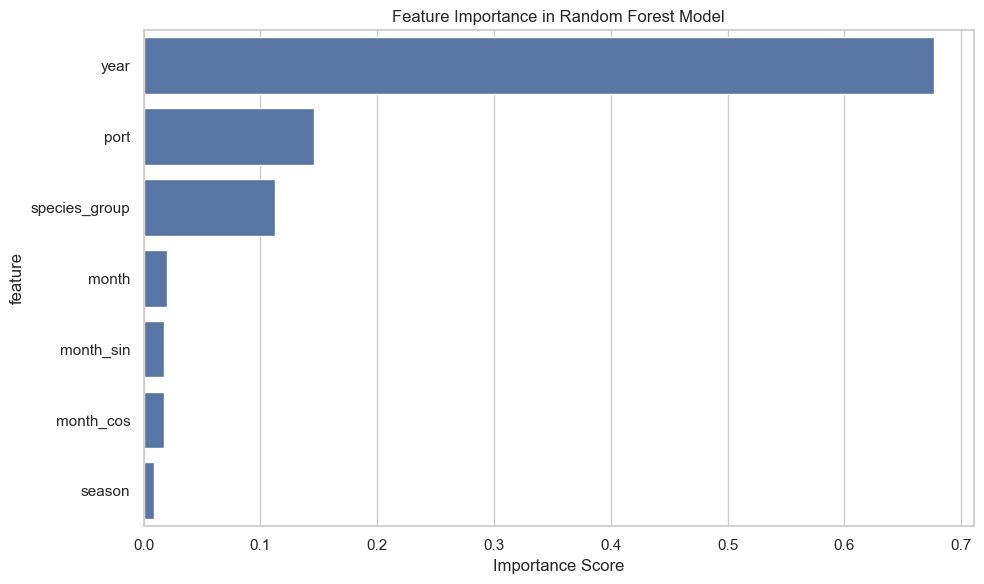


Model Comparison:
           Model  Accuracy
0    Naive Bayes  0.300642
1  Random Forest  0.420208

Prediction Probabilities for First 5 Test Samples:

Naive Bayes Probabilities:
       poor      fair      good  excellent
0  0.283543  0.261418  0.242383   0.212656
1  0.403606  0.231459  0.210795   0.154140
2  0.201148  0.267730  0.243733   0.287389
3  0.222358  0.222405  0.286167   0.269071
4  0.348767  0.256333  0.215221   0.179678

Random Forest Probabilities:
       poor      fair      good  excellent
0  0.000000  0.020000  0.110000   0.870000
1  0.030000  0.490000  0.170000   0.310000
2  0.030000  0.587500  0.013333   0.369167
3  0.795194  0.000000  0.204806   0.000000
4  0.563333  0.396667  0.000000   0.040000


In [23]:
# Visualization of results
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['poor', 'fair', 'good', 'excellent'],
                yticklabels=['poor', 'fair', 'good', 'excellent'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot confusion matrices
print("Naive Bayes Confusion Matrix:")
plot_confusion_matrix(y_test, nb_pred, 'Naive Bayes Confusion Matrix')

print("\nRandom Forest Confusion Matrix:")
plot_confusion_matrix(y_test, rf_pred, 'Random Forest Confusion Matrix')

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Compare model performances
model_comparison = pd.DataFrame({
    'Model': ['Naive Bayes', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, nb_pred),
        accuracy_score(y_test, rf_pred)
    ]
})
print("\nModel Comparison:")
print(model_comparison)

# Calculate and display prediction probabilities for a few examples
print("\nPrediction Probabilities for First 5 Test Samples:")
print("\nNaive Bayes Probabilities:")
nb_probs = nb_model.predict_proba(X_test[:5])
print(pd.DataFrame(nb_probs, columns=['poor', 'fair', 'good', 'excellent']))

print("\nRandom Forest Probabilities:")
rf_probs = rf_model.predict_proba(X_test[:5])
print(pd.DataFrame(rf_probs, columns=['poor', 'fair', 'good', 'excellent']))

## Step 6: Describe And Interpret The Model

**Initial Regression Attempts**
The first modeling attempts used Linear Regression and ARIMA time series approaches, both showing poor performance. The Linear Regression achieved only 16% explained variance (R-squared), while the ARIMA model's error (RMSE) was almost triple that of linear regression. These results weren't surprising given the high variability in landing volumes shown in the exploratory data analysis phase. The temporal patterns proved too complex for simple regression modeling.

**Classification Model Implementation**
After pivoting to classification approaches, initial results showed promise but room for improvement. The Random Forest classifier achieved 45% accuracy while Naive Bayes reached about 30% accuracy when predicting four fishing success levels. Feature importance analysis from the Random Forest revealed temporal features (Year and Month) dominated the model's decisions, accounting for approximately 80% of predictive power, while spatial and species features only contributed about 10% each.

**Enhanced Feature Engineering**
A second iteration attempted to improve performance through sophisticated feature engineering. This included creating proper seasonal groupings, implementing cyclical month encoding to better represent temporal relationships, and developing interaction features between ports and seasons. However, these enhancements actually resulted in slightly decreased performance - Naive Bayes dropped to 30.06% and Random Forest to 42.02% accuracy.

**Crab-Specific Classification Model**
A third iteration focused exclusively on crab species data, aiming to improve prediction accuracy through specialization. This included filtering for crab landings only, retaining temporal features (year, month, cyclical encodings), spatial features (port), and seasonal groupings. The model maintained balanced class distributions (~25% per success level) but showed slightly reduced performance - Naive Bayes achieved 27.71% accuracy and Random Forest reached 41.22% accuracy. Feature importance analysis revealed temporal patterns (year, month) and port location dominated predictive power, while seasonal indicators had minimal impact. The specialized approach, while providing clearer interpretability for crab-specific patterns, suggests that fishing success complexity exists even within a single species group and may require additional environmental or ecological variables to improve predictive performance.